# Import libraries and read data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

In [2]:
predict = pd.read_csv('admission_predict.csv')
predict.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [3]:
predict = predict.drop('Serial No.', axis=1)
predict.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


# Check percentage of NaN in each column

In [4]:
for column in predict.columns:
    num_nans = predict[column].isna().sum()
    print('percentage of NaNs for {}: {:.3f}'.format(
        column, 
        num_nans / len(predict) * 100
    ))

percentage of NaNs for GRE Score: 0.000
percentage of NaNs for TOEFL Score: 0.000
percentage of NaNs for University Rating: 0.000
percentage of NaNs for SOP: 0.000
percentage of NaNs for LOR: 0.000
percentage of NaNs for CGPA: 0.000
percentage of NaNs for Research: 0.000
percentage of NaNs for Chance of Admit: 0.000


# Draw correlation heatmap

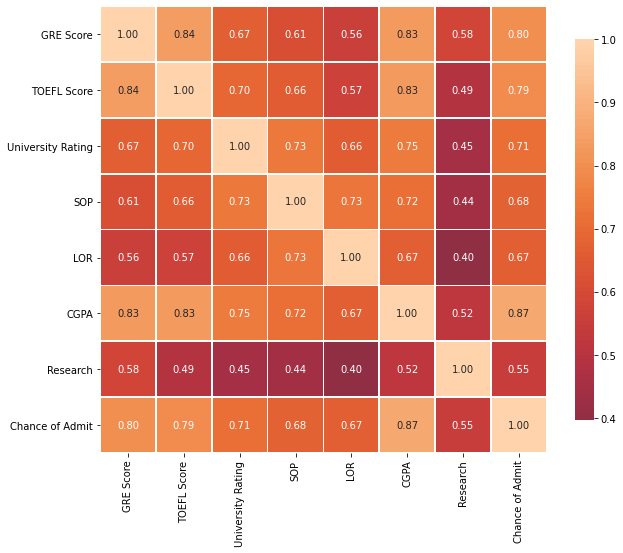

In [5]:
def draw_correlation_heatmap(df):
    """
    params:
    - df: dataframe of which correlation heatmap is drawn
    """
    fig, ax = plt.subplots(figsize=(10,10))

    sns.heatmap(
        df.corr(), 
        vmax=1.0, 
        center=0, 
        fmt='.2f',
        square=True, 
        linewidths=0.5, 
        annot=True, 
        cbar_kws={'shrink': .70},
    )

    plt.show()

draw_correlation_heatmap(predict)

We can observe that GPA, TOEFL and GRE score are highly correlated to the target variable chance of admitmmmm

# Perform RFECV

In [6]:
X = predict.drop('Chance of Admit', axis=1)
y = predict['Chance of Admit'].astype('float64')

In [7]:
y.head()

0    0.92
1    0.76
2    0.72
3    0.80
4    0.65
Name: Chance of Admit, dtype: float64

In [8]:
print(X.shape)
print(y.shape)

(400, 7)
(400,)


## Functions 

In [9]:
def plot_acc_vs_num_features(grid_scores, method_used):
    plt.figure(figsize=(16, 9))
    plt.title(method_used, fontsize=18, fontweight='bold', pad=20)

    plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
    plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)

    plt.plot(
        range(1, len(grid_scores) + 1), 
        grid_scores, 
        color='#303F9F', 
        linewidth=3,
    )

    plt.show()
    
def get_important_features(features_dataframe, rfecv, verbose=True):
    least_important_features = np.where(rfecv.support_ == False)[0]

    if verbose:
        print('not-important features:', list(features_dataframe.columns[least_important_features]))

    important_features_dataframe = features_dataframe.drop(
        features_dataframe.columns[least_important_features], 
        axis=1
    )

    if verbose:
        print('important features:', list(important_features_dataframe.columns))

    return important_features_dataframe

def plot_feature_importance_chart(important_features_dataframe, rfecv):
    plot_dataframe = pd.DataFrame()

    plot_dataframe['attr'] = important_features_dataframe.columns
    plot_dataframe['importance'] = rfecv.estimator_.feature_importances_

    plot_dataframe = plot_dataframe.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(16, 14))
    plt.barh(
        y=plot_dataframe['attr'], 
        width=plot_dataframe['importance'], 
        color='#1976D2',
    )

    plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
    plt.xlabel('Importance', fontsize=14, labelpad=20)

    plt.show()

## DecisionTreeClassifier

=====================GRID SCORES=====================
[0.59550227 0.5392944  0.48449175 0.51597846 0.5295635  0.52593601
 0.53489138]
=====================FEATURE RANKING=====================
feature: GRE Score rank: 2
feature: TOEFL Score rank: 3
feature: University Rating rank: 6
feature: SOP rank: 4
feature: LOR rank: 5
feature: CGPA rank: 1
feature: Research rank: 7
===================== MOST IMPORTANT FEATURES=====================
not-important features: [&#39;GRE Score&#39;, &#39;TOEFL Score&#39;, &#39;University Rating&#39;, &#39;SOP&#39;, &#39;LOR&#39;, &#39;Research&#39;]
important features: [&#39;CGPA&#39;]


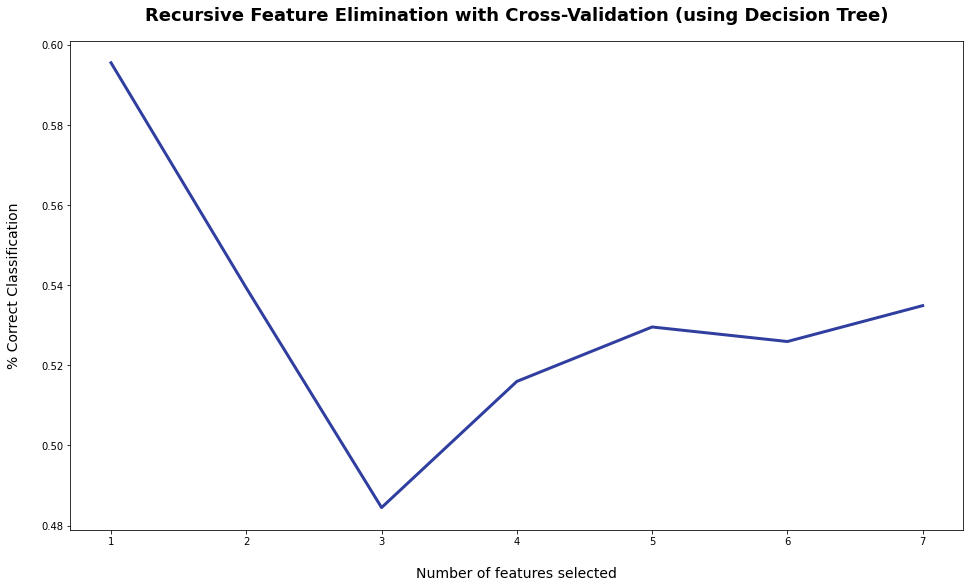

In [10]:
rfecv = RFECV(estimator=DecisionTreeRegressor(), cv=5)
rfecv = rfecv.fit(X,y)

print("=====================GRID SCORES=====================")
print(rfecv.grid_scores_)
print("=====================FEATURE RANKING=====================")
for column, rank in zip(X.columns, rfecv.ranking_):
    print(f'feature: {column} rank: {rank}')
print("===================== MOST IMPORTANT FEATURES=====================")
most_important_features = get_important_features(X, rfecv)

plot_acc_vs_num_features(
    rfecv.grid_scores_, 
    'Recursive Feature Elimination with Cross-Validation (using Decision Tree)', 
)

In [11]:
y.dtype

dtype(&#39;float64&#39;)

=====================GRID SCORES=====================
[0.73724026 0.73150834 0.72445246 0.71669554 0.72329272 0.71722834
 0.7089516 ]
=====================FEATURE RANKING=====================
feature: GRE Score rank: 2
feature: TOEFL Score rank: 3
feature: University Rating rank: 6
feature: SOP rank: 4
feature: LOR rank: 5
feature: CGPA rank: 1
feature: Research rank: 7
===================== MOST IMPORTANT FEATURES=====================
not-important features: [&#39;GRE Score&#39;, &#39;TOEFL Score&#39;, &#39;University Rating&#39;, &#39;SOP&#39;, &#39;LOR&#39;, &#39;Research&#39;]
important features: [&#39;CGPA&#39;]


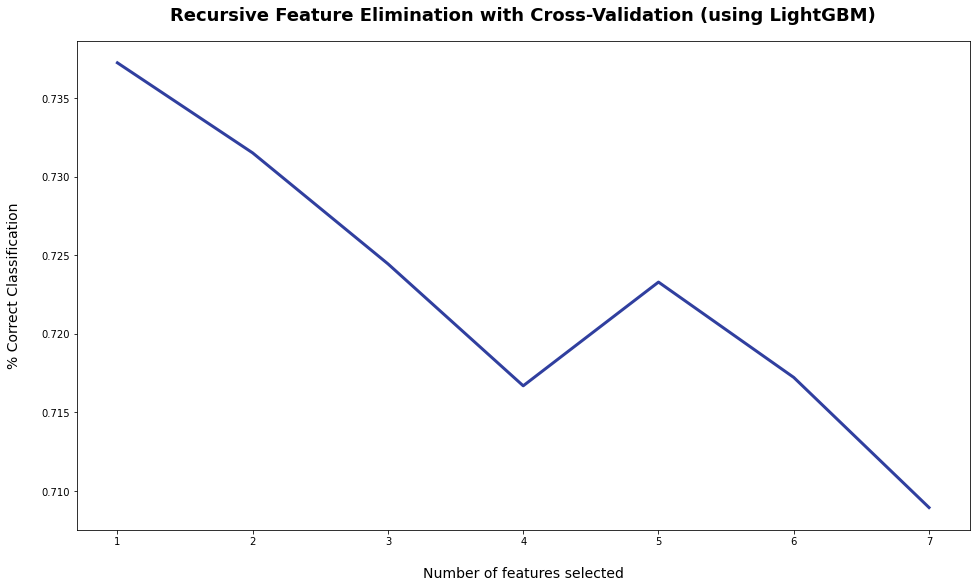

In [12]:
rfecv = RFECV(estimator=LGBMRegressor(), cv=5)
rfecv = rfecv.fit(X,y)

print("=====================GRID SCORES=====================")
print(rfecv.grid_scores_)
print("=====================FEATURE RANKING=====================")
for column, rank in zip(X.columns, rfecv.ranking_):
    print(f'feature: {column} rank: {rank}')
print("===================== MOST IMPORTANT FEATURES=====================")
most_important_features = get_important_features(X, rfecv)

plot_acc_vs_num_features(
    rfecv.grid_scores_, 
    'Recursive Feature Elimination with Cross-Validation (using LightGBM)', 
)

=====================GRID SCORES=====================
[0.75409676 0.76067937 0.76484268 0.76469003 0.76799293 0.77521245
 0.77117941]
=====================FEATURE RANKING=====================
feature: GRE Score rank: 2
feature: TOEFL Score rank: 1
feature: University Rating rank: 1
feature: SOP rank: 1
feature: LOR rank: 1
feature: CGPA rank: 1
feature: Research rank: 1
===================== MOST IMPORTANT FEATURES=====================
not-important features: [&#39;GRE Score&#39;]
important features: [&#39;TOEFL Score&#39;, &#39;University Rating&#39;, &#39;SOP&#39;, &#39;LOR&#39;, &#39;CGPA&#39;, &#39;Research&#39;]


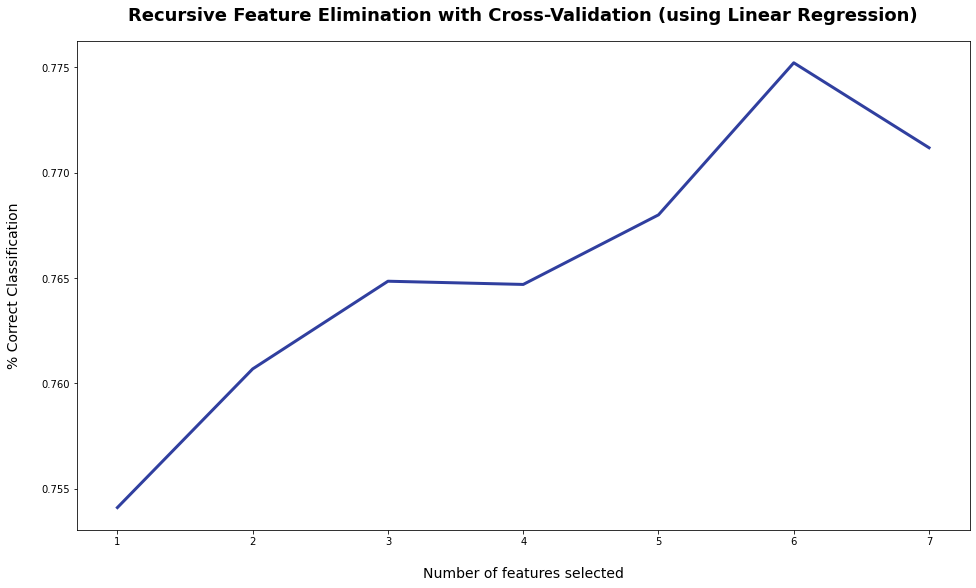

In [13]:
rfecv = RFECV(estimator=linear_model.LinearRegression(), cv=5)
rfecv = rfecv.fit(X,y)

print("=====================GRID SCORES=====================")
print(rfecv.grid_scores_)
print("=====================FEATURE RANKING=====================")
for column, rank in zip(X.columns, rfecv.ranking_):
    print(f'feature: {column} rank: {rank}')
print("===================== MOST IMPORTANT FEATURES=====================")
most_important_features = get_important_features(X, rfecv)

plot_acc_vs_num_features(
    rfecv.grid_scores_, 
    'Recursive Feature Elimination with Cross-Validation (using Linear Regression)', 
)

# Random Forest

=====================GRID SCORES=====================
[0.33054269 0.46487723 0.55448182 0.66424056 0.6715724  0.67105217
 0.70825172]
=====================FEATURE RANKING=====================
feature: GRE Score rank: 1
feature: TOEFL Score rank: 1
feature: University Rating rank: 1
feature: SOP rank: 1
feature: LOR rank: 1
feature: CGPA rank: 1
feature: Research rank: 1
===================== MOST IMPORTANT FEATURES=====================
not-important features: []
important features: [&#39;GRE Score&#39;, &#39;TOEFL Score&#39;, &#39;University Rating&#39;, &#39;SOP&#39;, &#39;LOR&#39;, &#39;CGPA&#39;, &#39;Research&#39;]


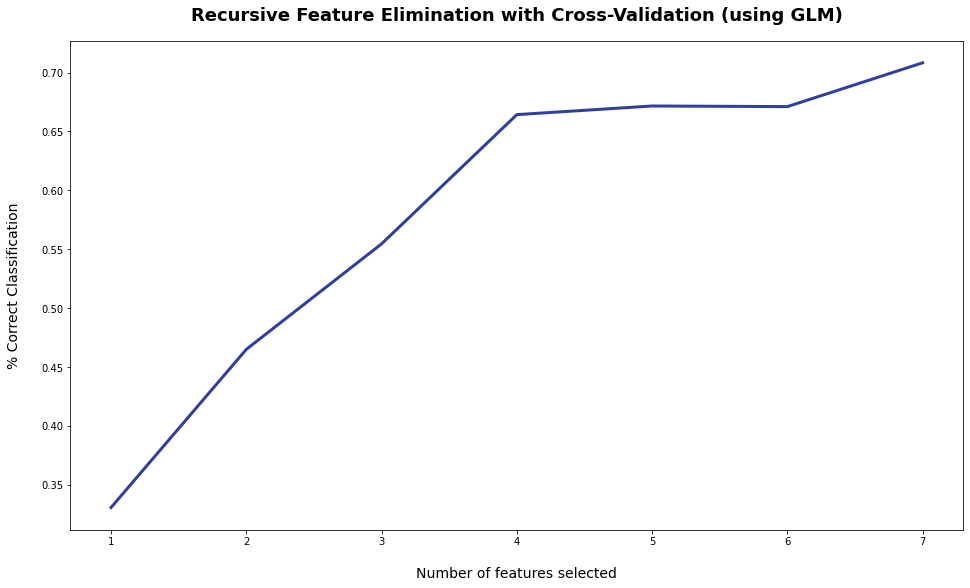

In [17]:
rfecv = RFECV(estimator=RandomForestRegressor(), cv=5)
rfecv = rfecv.fit(X,y)

print("=====================GRID SCORES=====================")
print(rfecv.grid_scores_)
print("=====================FEATURE RANKING=====================")
for column, rank in zip(X.columns, rfecv.ranking_):
    print(f'feature: {column} rank: {rank}')
print("===================== MOST IMPORTANT FEATURES=====================")
most_important_features = get_important_features(X, rfecv)

plot_acc_vs_num_features(
    rfecv.grid_scores_, 
    'Recursive Feature Elimination with Cross-Validation (using GLM)', 
)